In [1]:
from functools import partial

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import pandas as pd
from scipy.integrate import solve_ivp
import seaborn as sns
from jk_utils import (
    construct_vandermonde,
    trigonometric_polynomial,
    trigonometric_polynomial_centered,
)
from common import setup_plotting, PAPER_WIDTH_IN, OUTPUT_DIR, EXPORT_DPI

%load_ext autoreload
%autoreload 2

In [2]:
setup_plotting()

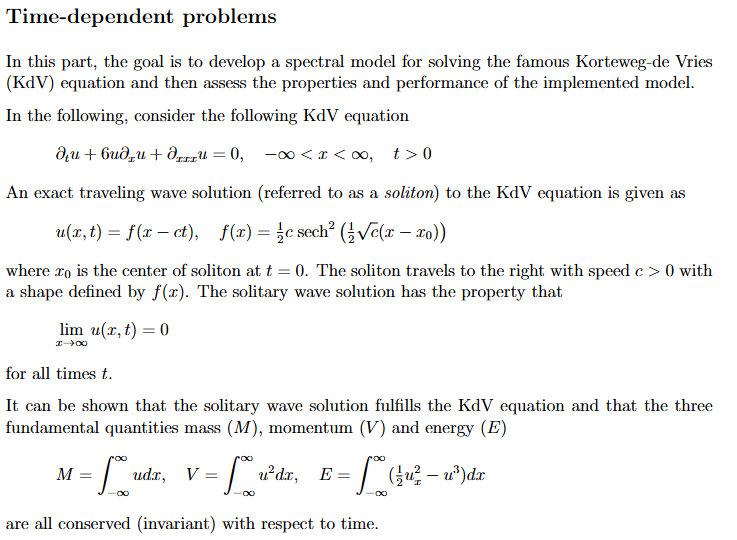

# 2.c
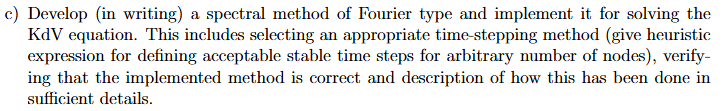

t=0.000, error=0.00e+00
t=0.333, error=6.51e-04
t=0.667, error=6.78e-04
t=1.000, error=3.29e-04
t=1.333, error=7.86e-04
t=1.667, error=1.67e-03
t=2.000, error=2.50e-03
t=2.333, error=3.13e-03
t=2.667, error=3.53e-03
t=3.000, error=3.64e-03


c:\Users\jeppe\Documents\MEGA\Base\DTU\02689 Advanced Numerical Methods\Assignments\.venv\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\jeppe\Documents\MEGA\Base\DTU\02689 Advanced Numerical Methods\Assignments\.venv\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


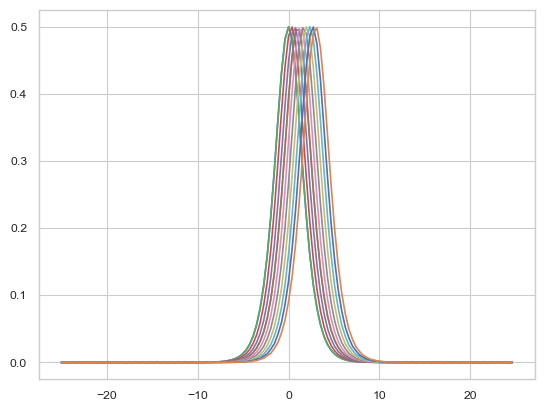

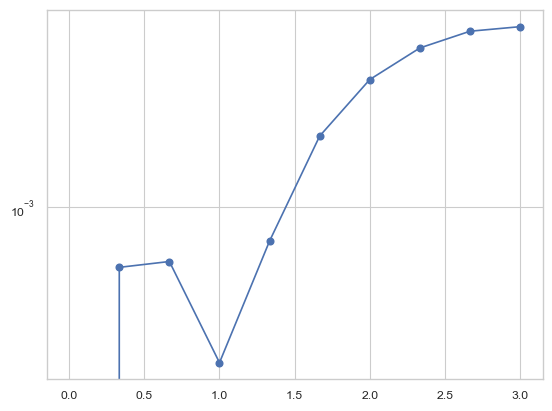

In [ ]:
# Domain
a = -25.0
b = -a
L = b - a

# Discretisation
N_grid = 128
N = N_grid - 1  # Polynomial degree

# Problem parameters
c = 1.0  # Wave speed, c > 0
x_0 = 0.0  # Initial position of the soliton

# Basis functions
basis_func = partial(trigonometric_polynomial_centered, k=0, N=N_grid, L=L)
basis_func_grad = partial(trigonometric_polynomial_centered, k=1, N=N_grid, L=L)

# Set up nodes
x = np.linspace(a, b, N_grid, endpoint=False)  # No last point since we impose periodicity

def travelling_soliton(x: npt.NDArray[np.float64], t: float) -> npt.NDArray[np.float64]:
    x_prime = x - c * t

    sech_argument = np.sqrt(c) * (x_prime - x_0) / 2.0
    f = 1/2 * c * (1 / np.cosh(sech_argument)) ** 2

    return f

plt.figure()
plt.plot(x, travelling_soliton(x, t=0.0), label="t=0")

# Set up differentiation matrix
V = construct_vandermonde(x, N_grid, basis_func, dtype=np.complex128)
V_x = construct_vandermonde(x, N_grid, basis_func_grad, dtype=np.complex128)
D = np.linalg.solve(V.T, V_x.T).T  # D = V_x * V^{-1}, right solve
D3 = D @ D @ D

# Set up initial condition
u_0 = travelling_soliton(x, t=0.0).astype(np.complex128)

# Simulation time
t_0 = 0.0
t_final = 3.0
N_eval = 10
t_eval = np.linspace(t_0, t_final, N_eval, endpoint=True)

# Set up differential equation operator
def eval_timestep(t: float, u: npt.NDArray[np.complex128]) -> npt.NDArray[np.complex128]:
    """Evaluate the time derivative du/dt at time t and state u."""
    u_x = D @ u
    uu_x = u * u_x
    u_xxx = D3 @ u
    return -6 * uu_x - u_xxx

solve_result = solve_ivp(eval_timestep, (t_0, t_final), u_0, method="RK45", t_eval=t_eval)

plt.plot(x, np.real(solve_result.y[:, 3]))

for t, u in zip(solve_result.t, solve_result.y.T):
    plt.plot(x, u.T, label=f"t={t:.3f}")

# Compare errors
data = []
for t, u_numeric in zip(solve_result.t, solve_result.y.T):
    u_exact = travelling_soliton(x, t)
    error = np.linalg.norm(u_exact - np.real(u_numeric), ord=2)
    relative_error = error / np.linalg.norm(u_exact, ord=2)
    data.append({
        "t": t,
        "error": error,
        "relative_error": relative_error,
    })
    print(f"t={t:.3f}, error={error:.2e}")

df = pd.DataFrame(data)
plt.figure()
plt.semilogy(df["t"], df["error"], "-o", label="L2 Error")

In [24]:
data = []
for N_grid in [4, 8, 16, 32, 64, 128, 256]:
    N = N_grid - 1  # Polynomial degree

    # Domain
    a = -15.0
    b = -a
    L = b - a

    # Problem parameters
    c = 1.0  # Wave speed, c > 0
    x_0 = -5.0  # Initial position of the soliton

    # Basis functions
    basis_func = partial(trigonometric_polynomial_centered, k=0, N=N_grid, L=L)
    basis_func_grad = partial(trigonometric_polynomial_centered, k=1, N=N_grid, L=L)

    # Set up nodes
    x = np.linspace(a, b, N_grid, endpoint=False)  # No last point since we impose periodicity

    # Set up differentiation matrix
    V = construct_vandermonde(x, N_grid, basis_func, dtype=np.complex128)
    V_x = construct_vandermonde(x, N_grid, basis_func_grad, dtype=np.complex128)
    D = np.linalg.solve(V.T, V_x.T).T  # D = V_x * V^{-1}, right solve
    D3 = D @ D @ D

    # Set up initial condition
    u_0 = travelling_soliton(x, t=0.0).astype(np.complex128)

    # Simulation time
    t_0 = 0.0
    t_final = 3.0

    # Set up differential equation operator
    def eval_timestep(t: float, u: npt.NDArray[np.complex128]) -> npt.NDArray[np.complex128]:
        """Evaluate the time derivative du/dt at time t and state u."""
        u_x = D @ u
        uu_x = u * u_x
        u_xxx = D3 @ u
        return -6 * uu_x - u_xxx

    solve_result = solve_ivp(eval_timestep, (t_0, t_final), u_0, method="BDF")

    # Compute error
    u_final_numeric = solve_result.y[:, -1]
    u_final_exact = travelling_soliton(x, t_final)
    error = np.linalg.norm(u_final_exact - np.real(u_final_numeric), ord=2)
    relative_error = error / np.linalg.norm(u_final_exact, ord=2)

    data.append({
        "N": N,
        "t": t_final,
        "solve_result": solve_result,
        "error": error,
        "relative_error": relative_error,
    })


[]

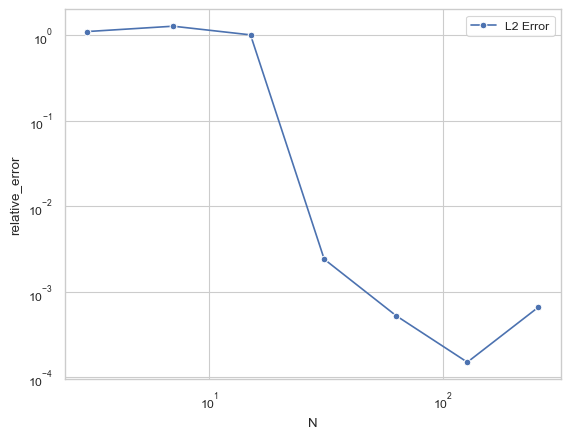

In [25]:
df = pd.DataFrame(data)
plt.figure()
sns.lineplot(data=df, x="N", y="relative_error", marker="o", label="L2 Error")
plt.loglog()

In [28]:
for d in data:
    print(np.mean(np.diff(d["solve_result"].t)))

0.2727272727272727
0.16666666666666666
0.06521739130434782
0.015789473684210527
0.0020604395604395605
0.0002370042660767894
0.05084745762711865


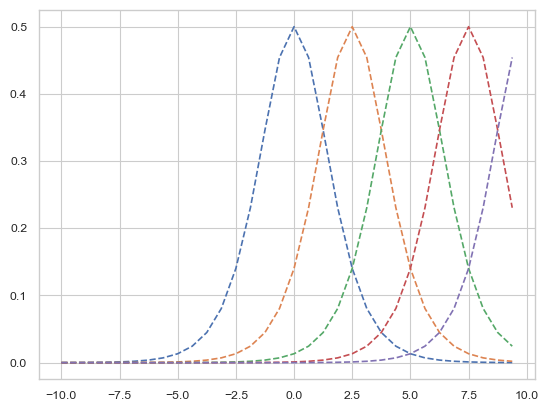

In [4]:
for t in np.linspace(0, 10, 5):
    plt.plot(x, travelling_soliton(x, t), "--", label=f"t={t:.3f}")